#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

In [75]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import numpy as np
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [25]:
# %%time
# # Import Configuration file
# i = pybna.Importer(config="config.yaml")
# # Import Study Area boundary shape file
# i.import_boundary('City_of_Davis_Boundary.shp', overwrite=True)
# # Mention the State fips, for California it is 6
# i.import_census_blocks(fips=6, overwrite=True)
# i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

In [26]:
# %%time
# i.import_osm_network(overwrite=True)

In [27]:
# %%time
# # stress
# s = pybna.Stress(config='config.yaml')
# s.segment_stress()
# s.crossing_stress()

In [28]:
# Read the LTS shape file
lts=gpd.read_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/share with alex s/share with alex s/comprehensive_data_set.shp")
lts['length']=lts.length
lts.head()

,fid_,road_id,osm_functi,osm_ft_lan,osm_tf_lan,osm_speed,osm_tf_bik,osm_ft_bik,osm_oneway,city,...,exist_lts_,exist_lts1,planned_lt,planned__1,lts_tomap_,lts_tomap1,geom_Lengt,exist_lt_1,geometry,length
0,0,15,None,0,0,0,None,None,None,hayward,...,3,3,0,0,3,0,283.833562,3,"LINESTRING (585796.274 4168917.387, 585815.157...",283.833562
1,0,844,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,34.070050,1,"LINESTRING (585376.499 4167063.203, 585408.746...",34.070050
2,0,57338,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,2.615091,1,"LINESTRING (582375.868 4165538.720, 582377.162...",2.615091
3,0,5423,secondary,3,0,0,None,None,None,hayward,...,4,4,4,4,4,0,3.068993,4,"LINESTRING (578387.624 4165593.723, 578389.963...",3.068993
4,0,7139,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,61.315594,1,"LINESTRING (577068.837 4164506.246, 577072.821...",61.315594


In [29]:
lts.crs

<Derived Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
#lts=lts0.to_crs('EPSG:26910')
#lts.head()

# Lets calculate the slope for each link

In [31]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

In [32]:
# Open the raster image
barea_slope = rasterio.open('H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Slope/Slope/cslope11.img')
print(barea_slope.crs)
#rioplot.show(barea_slope)

EPSG:4269


In [33]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -104, 'mean': 236.201825257043, 'max': 1784}


In [34]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,fid_,road_id,osm_functi,osm_ft_lan,osm_tf_lan,osm_speed,osm_tf_bik,osm_ft_bik,osm_oneway,city,...,exist_lts_,exist_lts1,planned_lt,planned__1,lts_tomap_,lts_tomap1,geom_Lengt,exist_lt_1,geometry,length
0,0,15,None,0,0,0,None,None,None,hayward,...,3,3,0,0,3,0,283.833562,3,"LINESTRING (-122.02723 37.66343, -122.02702 37...",283.833562
1,0,844,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,34.070050,1,"LINESTRING (-122.03221 37.64675, -122.03185 37...",34.070050
2,0,57338,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,2.615091,1,"LINESTRING (-122.06639 37.63329, -122.06638 37...",2.615091
3,0,5423,secondary,3,0,0,None,None,None,hayward,...,4,4,4,4,4,0,3.068993,4,"LINESTRING (-122.11158 37.63413, -122.11155 37...",3.068993
4,0,7139,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,61.315594,1,"LINESTRING (-122.12664 37.62444, -122.12659 37...",61.315594
5,0,9497,residential,0,0,0,sharrow,sharrow,None,hayward,...,3,3,3,3,3,0,43.498009,3,"LINESTRING (-122.08311 37.66445, -122.08267 37...",43.498009
6,0,452928,None,0,0,0,None,None,None,hayward,...,3,3,0,0,3,0,184.093268,3,"LINESTRING (-122.03585 37.60597, -122.03593 37...",184.093268
7,0,56226,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,2.174155,1,"LINESTRING (-122.08323 37.61448, -122.08321 37...",2.174155
8,0,31861,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,2.603041,1,"LINESTRING (-122.12347 37.63329, -122.12350 37...",2.603041
9,0,33556,residential,0,0,0,None,None,None,hayward,...,1,1,1,1,1,0,1.536087,1,"LINESTRING (-122.12445 37.64633, -122.12446 37...",1.536087


In [35]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot: >

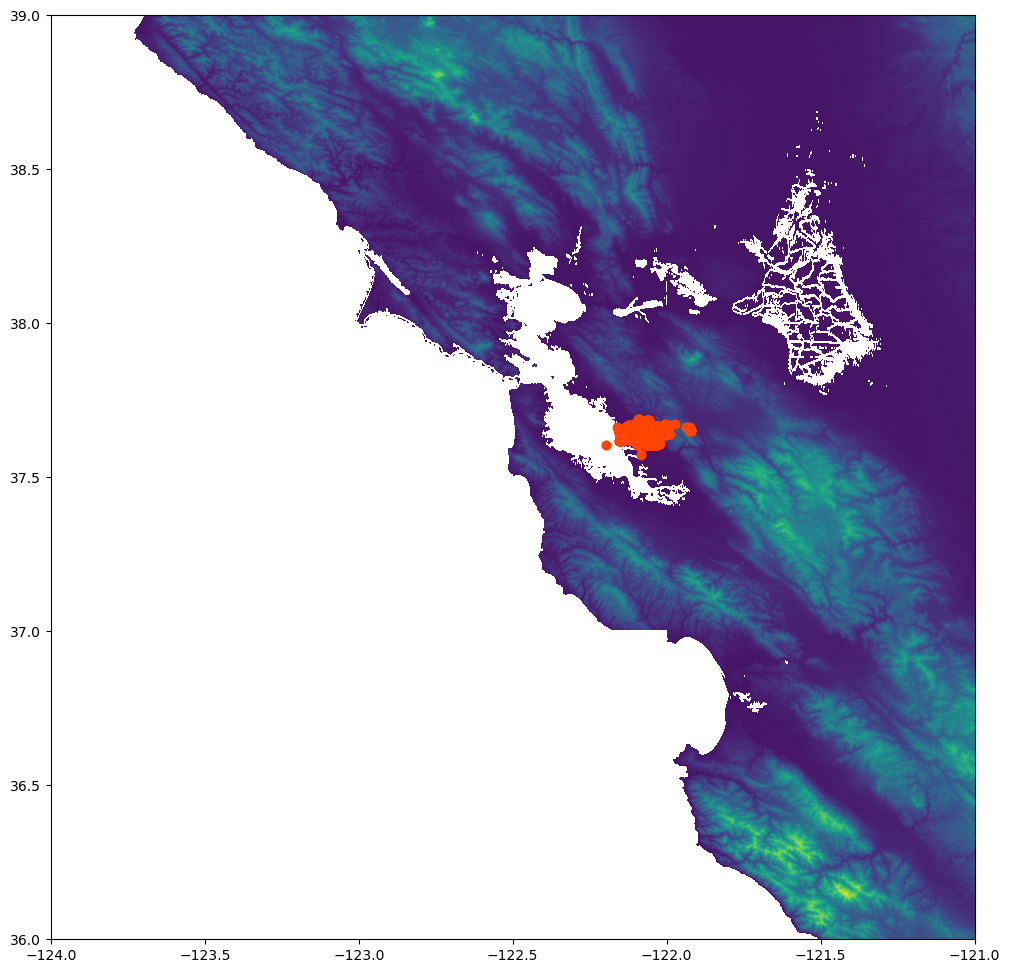

In [36]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [37]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["road_id","starting point"]]
sf1.columns=["road_id","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["road_id","geometry","start_lon","start_lat"]]
sf2.head(5)

,road_id,geometry,start_lon,start_lat
0,15,POINT (-122.02723413773181 37.66342523924798),-122.027234,37.663425
1,844,POINT (-122.03220993188853 37.64675419972342),-122.032210,37.646754
2,57338,POINT (-122.06639148391989 37.633289325304354),-122.066391,37.633289
3,5423,POINT (-122.1115812714389 37.63413409482137),-122.111581,37.634134
4,7139,POINT (-122.12664104937484 37.62444489289135),-122.126641,37.624445


In [38]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [39]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["road_id","ending point"]]
ef1.columns=["road_id","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["road_id","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 203 ms
Wall time: 168 ms


,road_id,geometry,end_lon,end_lat
0,15,POINT (-122.02586241719034 37.66127720734803),-122.025862,37.661277
1,844,POINT (-122.0318457325202 37.646652099534194),-122.031846,37.646652
2,57338,POINT (-122.0663770844215 37.633268725287515),-122.066377,37.633269
3,5423,POINT (-122.11155497132684 37.63411599470061),-122.111555,37.634116
4,7139,POINT (-122.1265894489374 37.624995994307156),-122.126589,37.624996


In [40]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 4.97 s
Wall time: 4.99 s


In [41]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['road_id'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['road_id'], keep='first')
barea_all1.head()

CPU times: total: 109 ms
Wall time: 108 ms


,road_id,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,fid_,...,planned__1,lts_tomap_,lts_tomap1,geom_Lengt,exist_lt_1,geometry,length,starting point,ending point,slope
0,15,POINT (-122.02723413773181 37.66342523924798),-122.027234,37.663425,321,POINT (-122.02586241719034 37.66127720734803),-122.025862,37.661277,316,0,...,0,3,0,283.833562,3,"LINESTRING (-122.02723 37.66343, -122.02702 37...",283.833562,POINT (-122.02723413773181 37.66342523924798),POINT (-122.02586241719034 37.66127720734803),1.761596
1,844,POINT (-122.03220993188853 37.64675419972342),-122.032210,37.646754,207,POINT (-122.0318457325202 37.646652099534194),-122.031846,37.646652,212,0,...,1,1,0,34.070050,1,"LINESTRING (-122.03221 37.64675, -122.03185 37...",34.070050,POINT (-122.03220993188853 37.64675419972342),POINT (-122.0318457325202 37.646652099534194),14.675646
2,57338,POINT (-122.06639148391989 37.633289325304354),-122.066391,37.633289,7,POINT (-122.0663770844215 37.633268725287515),-122.066377,37.633269,7,0,...,1,1,0,2.615091,1,"LINESTRING (-122.06639 37.63329, -122.06638 37...",2.615091,POINT (-122.06639148391989 37.633289325304354),POINT (-122.0663770844215 37.633268725287515),0.000000
3,5423,POINT (-122.1115812714389 37.63413409482137),-122.111581,37.634134,8,POINT (-122.11155497132684 37.63411599470061),-122.111555,37.634116,8,0,...,4,4,0,3.068993,4,"LINESTRING (-122.11158 37.63413, -122.11155 37...",3.068993,POINT (-122.1115812714389 37.63413409482137),POINT (-122.11155497132684 37.63411599470061),0.000000
4,7139,POINT (-122.12664104937484 37.62444489289135),-122.126641,37.624445,4,POINT (-122.1265894489374 37.624995994307156),-122.126589,37.624996,4,0,...,1,1,0,61.315594,1,"LINESTRING (-122.12664 37.62444, -122.12659 37...",61.315594,POINT (-122.12664104937484 37.62444489289135),POINT (-122.1265894489374 37.624995994307156),0.000000


<AxesSubplot: >

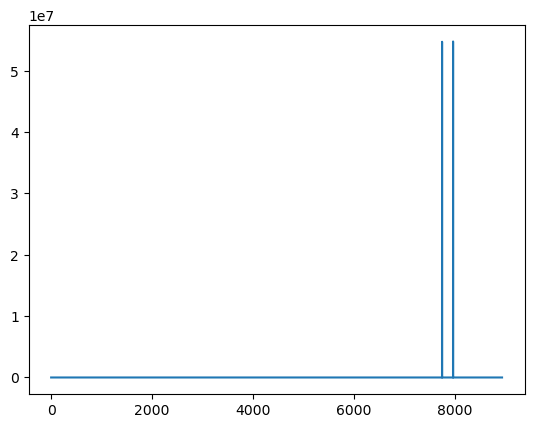

In [42]:
barea_all1.slope.plot()

In [43]:
# write a slope impedance function
def slope_correction(length,FT_SEG_STR,slope):
    if slope <=2:
        return length*(1+FT_SEG_STR)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+FT_SEG_STR)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+FT_SEG_STR)
    else:
        return length*(1+3.20+FT_SEG_STR)

In [44]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['exist_lts1']=pd.to_numeric(barea_all1['exist_lts1']).astype(int)
barea_all1['exist_lts1'].dtypes

dtype('int32')

In [45]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['exist_lts1'],row['slope']),axis=1)
barea_all1.head(8)

,road_id,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,fid_,...,lts_tomap_,lts_tomap1,geom_Lengt,exist_lt_1,geometry,length,starting point,ending point,slope,impedance_of_link
0,15,POINT (-122.02723413773181 37.66342523924798),-122.027234,37.663425,321,POINT (-122.02586241719034 37.66127720734803),-122.025862,37.661277,316,0,...,3,0,283.833562,3,"LINESTRING (-122.02723 37.66343, -122.02702 37...",283.833562,POINT (-122.02723413773181 37.66342523924798),POINT (-122.02586241719034 37.66127720734803),1.761596,1135.334248
1,844,POINT (-122.03220993188853 37.64675419972342),-122.032210,37.646754,207,POINT (-122.0318457325202 37.646652099534194),-122.031846,37.646652,212,0,...,1,0,34.070050,1,"LINESTRING (-122.03221 37.64675, -122.03185 37...",34.070050,POINT (-122.03220993188853 37.64675419972342),POINT (-122.0318457325202 37.646652099534194),14.675646,177.164258
2,57338,POINT (-122.06639148391989 37.633289325304354),-122.066391,37.633289,7,POINT (-122.0663770844215 37.633268725287515),-122.066377,37.633269,7,0,...,1,0,2.615091,1,"LINESTRING (-122.06639 37.63329, -122.06638 37...",2.615091,POINT (-122.06639148391989 37.633289325304354),POINT (-122.0663770844215 37.633268725287515),0.000000,5.230181
3,5423,POINT (-122.1115812714389 37.63413409482137),-122.111581,37.634134,8,POINT (-122.11155497132684 37.63411599470061),-122.111555,37.634116,8,0,...,4,0,3.068993,4,"LINESTRING (-122.11158 37.63413, -122.11155 37...",3.068993,POINT (-122.1115812714389 37.63413409482137),POINT (-122.11155497132684 37.63411599470061),0.000000,15.344965
4,7139,POINT (-122.12664104937484 37.62444489289135),-122.126641,37.624445,4,POINT (-122.1265894489374 37.624995994307156),-122.126589,37.624996,4,0,...,1,0,61.315594,1,"LINESTRING (-122.12664 37.62444, -122.12659 37...",61.315594,POINT (-122.12664104937484 37.62444489289135),POINT (-122.1265894489374 37.624995994307156),0.000000,122.631188
5,9497,POINT (-122.08311267797055 37.66444652000258),-122.083113,37.664447,29,POINT (-122.0826669796406 37.664278718823454),-122.082667,37.664279,29,0,...,3,0,43.498009,3,"LINESTRING (-122.08311 37.66445, -122.08267 37...",43.498009,POINT (-122.08311267797055 37.66444652000258),POINT (-122.0826669796406 37.664278718823454),0.000000,173.992035
6,452928,POINT (-122.03585145429392 37.60597286651636),-122.035851,37.605973,19,POINT (-122.03790799933434 37.60595767153385),-122.037908,37.605958,18,0,...,3,0,184.093268,3,"LINESTRING (-122.03585 37.60597, -122.03593 37...",184.093268,POINT (-122.03585145429392 37.60597286651636),POINT (-122.03790799933434 37.60595767153385),0.543203,736.373071
7,56226,POINT (-122.08323048207328 37.61447890828318),-122.083230,37.614479,3,POINT (-122.08320588132217 37.61447790772797),-122.083206,37.614478,3,0,...,1,0,2.174155,1,"LINESTRING (-122.08323 37.61448, -122.08321 37...",2.174155,POINT (-122.08323048207328 37.61447890828318),POINT (-122.08320588132217 37.61447790772797),0.000000,4.348311


### Lets Calculate the Connectivity

## Helper Function

In [46]:
def node_level_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_sheortst_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_sheortst_path_motor_length['total_motor_path']=sf_sheortst_path_motor_length.sum(numeric_only=True, axis=0)
    sf_sheortst_path_motor_length1=sf_sheortst_path_motor_length[['total_motor_path']]
    # make total motor path as dictonary
    ms_outcomes=sf_sheortst_path_motor_length1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_motor_g1, values=ms_outcomes, name="total_motor_path")
    nodes_motor, edges_motor = momepy.nx_to_gdf(sf_lts_motor_g1)
    nodes_motor['total_motor_path'] = nodes_motor['total_motor_path'].str[0]
    
    
    # do it for bike Path
    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=39590, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total bike path
    sf_shortest_path_bike_length['total_bike_path']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length1=sf_shortest_path_bike_length[['total_bike_path']]
    # make total motor path as dictonary
    bs_outcomes=sf_shortest_path_bike_length1.T.to_dict('list')
    # add motor path attribute with grpah nodes
    nx.set_node_attributes(sf_lts_bike_g1, values=bs_outcomes, name="total_bike_path")
    nodes_bike, edges_bike = momepy.nx_to_gdf(sf_lts_bike_g1)
    nodes_bike['total_bike_path'] = nodes_bike['total_bike_path'].str[0]

    #connectivity score
    shortest_path=pd.merge(nodes_motor,nodes_bike,on=['geometry'],how='outer')
    shortest_path1=shortest_path.fillna(0)
    shortest_path1['CS']= shortest_path1['total_bike_path']/shortest_path1['total_motor_path']
    shortest_path1= shortest_path1.replace(np.inf, 999)
    return shortest_path1 


In [47]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

In [48]:
def census_node_level_connectivity_score (sf_connectivity,input_census_tract):
    census_score=gpd.sjoin(sf_connectivity,input_census_tract)
    census_score1=pd.DataFrame({'Meadian CS':census_score.groupby(['GISJOIN'])['CS'].median()}).reset_index()
    census_score2=pd.merge(census_score1,input_census_tract, on=['GISJOIN'], how='inner' )
    return census_score2 

## Connectivity

In [49]:
# Bring US Census track
census_track=gpd.read_file('H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9825304.0,28435.0,+32.4819731,-086.4915648,16217.763443,9.853735e+06,"POLYGON ((3516926.098 77059.002, 3516963.104 7..."
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3320818.0,5669.0,+32.4757580,-086.4724678,9824.372415,3.326483e+06,"POLYGON ((3519482.809 73938.168, 3519490.446 7..."
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5349271.0,9054.0,+32.4740243,-086.4597033,10519.641206,5.358327e+06,"POLYGON ((3521117.478 74718.075, 3521099.105 7..."
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6384282.0,8408.0,+32.4710304,-086.4448353,12521.196228,6.392683e+06,"POLYGON ((3521674.809 77662.170, 3521681.008 7..."
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6203654.0,0.0,+32.4478607,-086.4225578,11422.446991,6.203654e+06,"POLYGON ((3525078.936 76191.813, 3525244.092 7..."


In [50]:
# read the Hayward boundary shape file
study_bd=gpd.read_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/data/COH_Jurisdictions.shp")
study_bd

,NAME,NAME_SHORT,POLITICAL_,NAME_ONLY,geometry
0,City of Hayward,None,None,None,"POLYGON ((6101644.000 2077601.000, 6101638.000..."


<AxesSubplot: >

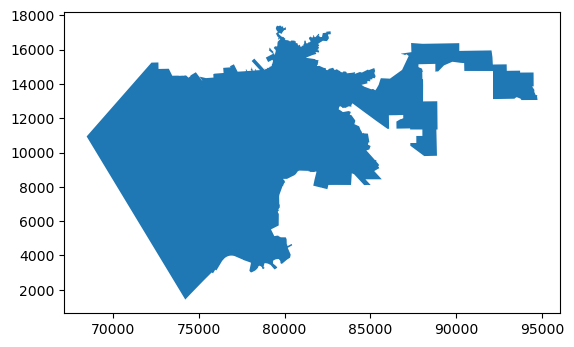

In [51]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [52]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
4480,G0600010441503,06,001,441503,06001441503,4415.03,Census Tract 4415.03,G5020,S,72745500.0,12525279.0,+37.4899766,-121.9742068,103457.981851,7.299653e+07,"MULTIPOLYGON (((77091.640 3959.938, 77082.247 ..."
4467,G0600010440332,06,001,440332,06001440332,4403.32,Census Tract 4403.32,G5020,S,2297853.0,0.0,+37.5828284,-122.0858891,9132.828879,2.297856e+06,"MULTIPOLYGON (((80274.013 4500.050, 80278.224 ..."
4466,G0600010440331,06,001,440331,06001440331,4403.31,Census Tract 4403.31,G5020,S,1761655.0,0.0,+37.5980622,-122.0829553,6734.568436,1.761655e+06,"MULTIPOLYGON (((79630.220 6669.121, 79630.178 ..."
4460,G0600010440301,06,001,440301,06001440301,4403.01,Census Tract 4403.01,G5020,S,4329374.0,0.0,+37.6012643,-122.0427413,11995.865886,4.329375e+06,"MULTIPOLYGON (((84706.414 8438.053, 84706.833 ..."
4468,G0600010440333,06,001,440333,06001440333,4403.33,Census Tract 4403.33,G5020,S,2505503.0,0.0,+37.6053298,-122.0738277,6953.455415,2.505502e+06,"MULTIPOLYGON (((81485.014 8891.584, 81497.287 ..."


In [54]:
census_track2.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Hayward Data/Hayward_City_cnesus_Tract.shp")

In [55]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

,NAME,NAME_SHORT,POLITICAL_,NAME_ONLY,geometry,area
0,City of Hayward,None,None,None,"POLYGON ((79760.338 17397.355, 79758.808 17382...",64.505348


In [56]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    64.505348
dtype: float64

In [57]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,road_id,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,fid_,...,lts_tomap_,lts_tomap1,geom_Lengt,exist_lt_1,geometry,length,starting point,ending point,slope,impedance_of_link
0,15,POINT (-122.02723413773181 37.66342523924798),-122.027234,37.663425,321,POINT (-122.02586241719034 37.66127720734803),-122.025862,37.661277,316,0,...,3,0,283.833562,3,"LINESTRING (85301.981 14475.008, 85320.740 144...",283.833562,POINT (-122.02723413773181 37.66342523924798),POINT (-122.02586241719034 37.66127720734803),1.761596,1135.334248
1,844,POINT (-122.03220993188853 37.64675419972342),-122.032210,37.646754,207,POINT (-122.0318457325202 37.646652099534194),-122.031846,37.646652,212,0,...,1,0,34.070050,1,"LINESTRING (84871.192 12622.697, 84903.384 126...",34.070050,POINT (-122.03220993188853 37.64675419972342),POINT (-122.0318457325202 37.646652099534194),14.675646,177.164258
2,57338,POINT (-122.06639148391989 37.633289325304354),-122.066391,37.633289,7,POINT (-122.0663770844215 37.633268725287515),-122.066377,37.633269,7,0,...,1,0,2.615091,1,"LINESTRING (81860.669 11115.330, 81861.949 111...",2.615091,POINT (-122.06639148391989 37.633289325304354),POINT (-122.0663770844215 37.633268725287515),0.000000,5.230181
3,5423,POINT (-122.1115812714389 37.63413409482137),-122.111581,37.634134,8,POINT (-122.11155497132684 37.63411599470061),-122.111555,37.634116,8,0,...,4,0,3.068993,4,"LINESTRING (77871.469 11193.745, 77873.797 111...",3.068993,POINT (-122.1115812714389 37.63413409482137),POINT (-122.11155497132684 37.63411599470061),0.000000,15.344965
4,7139,POINT (-122.12664104937484 37.62444489289135),-122.126641,37.624445,4,POINT (-122.1265894489374 37.624995994307156),-122.126589,37.624996,4,0,...,1,0,61.315594,1,"LINESTRING (76545.878 10113.646, 76550.222 101...",61.315594,POINT (-122.12664104937484 37.62444489289135),POINT (-122.1265894489374 37.624995994307156),0.000000,122.631188


In [58]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

,road_id,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,fid_,...,lts_tomap_,lts_tomap1,geom_Lengt,exist_lt_1,geometry,length,starting point,ending point,slope,impedance_of_link
758,29949,POINT (-122.08468375094148 37.573745168638034),-122.084684,37.573745,2,POINT (-122.08315034275466 37.5752921034496),-122.083150,37.575292,3,0,...,1,0,257.191771,1,"LINESTRING (80271.739 4500.060, 80264.820 4520...",257.191771,POINT (-122.08468375094148 37.573745168638034),POINT (-122.08315034275466 37.5752921034496),0.388815,514.383541
8789,341845,POINT (-122.08423568767502 37.6103998001538),-122.084236,37.610400,4,POINT (-122.08412606904528 37.610222417196894),-122.084126,37.610222,4,0,...,1,0,21.931053,1,"LINESTRING (80295.477 8568.516, 80305.232 8548...",21.931053,POINT (-122.08423568767502 37.6103998001538),POINT (-122.08412606904528 37.610222417196894),0.000000,43.862106
8106,232345,POINT (-122.08399354185667 37.61028851070051),-122.083994,37.610289,4,POINT (-122.08409358765421 37.61045499999182),-122.084094,37.610455,4,0,...,3,0,20.474802,3,"LINESTRING (80316.905 8556.247, 80308.000 8574...",20.474802,POINT (-122.08399354185667 37.61028851070051),POINT (-122.08409358765421 37.61045499999182),0.000000,81.899209
7146,304440,POINT (-122.0845827853063 37.61094730245381),-122.084583,37.610947,4,POINT (-122.08423568767502 37.6103998001538),-122.084236,37.610400,4,0,...,1,0,68.035764,1,"LINESTRING (80264.593 8629.164, 80295.477 8568...",68.035764,POINT (-122.0845827853063 37.61094730245381),POINT (-122.08423568767502 37.6103998001538),0.000000,136.071528
6530,420937,POINT (-122.08409358765421 37.61045499999182),-122.084094,37.610455,4,POINT (-122.08479198298402 37.61159640365748),-122.084792,37.611596,4,0,...,3,0,140.848994,3,"LINESTRING (80308.000 8574.692, 80245.841 8701...",140.848994,POINT (-122.08409358765421 37.61045499999182),POINT (-122.08479198298402 37.61159640365748),0.000000,563.395976


In [59]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

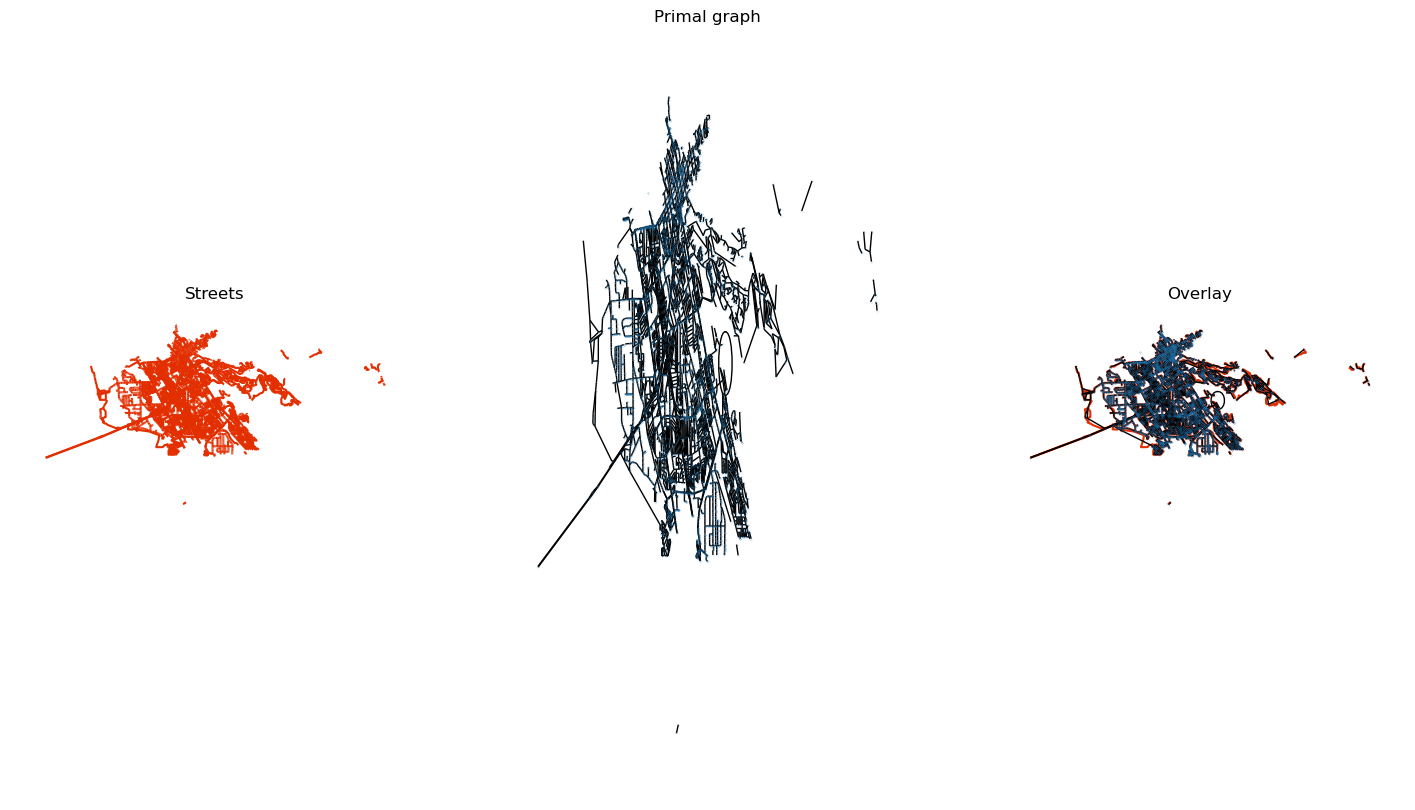

In [60]:
  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
  sf_lts.plot(color='#e32e00', ax=ax[0])
  for i, facet in enumerate(ax):
      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
      facet.axis("off")
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot: >

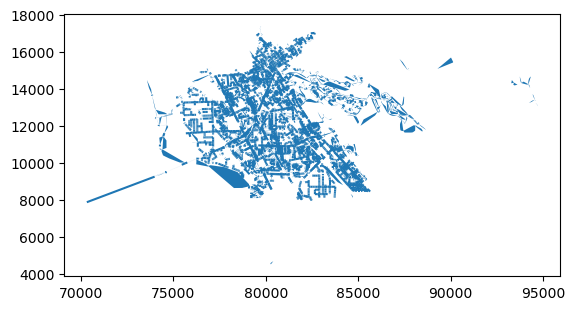

In [61]:
sf_lts['geometry'].convex_hull.plot()

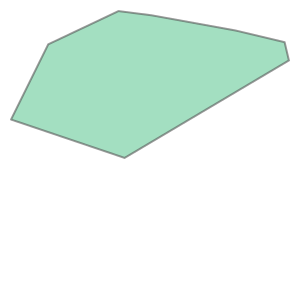

In [62]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot: >

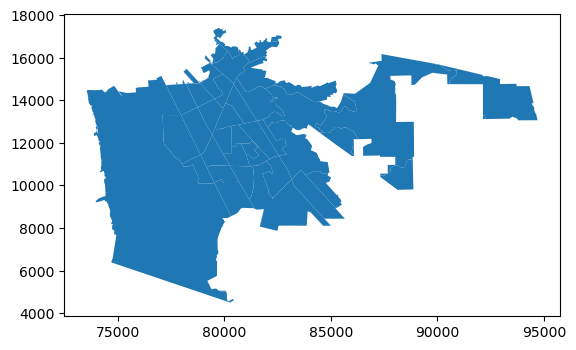

In [63]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [64]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

187656367.75340217

In [65]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [66]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [67]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

2725

# Bicycle  Network Connectivity

<AxesSubplot: >

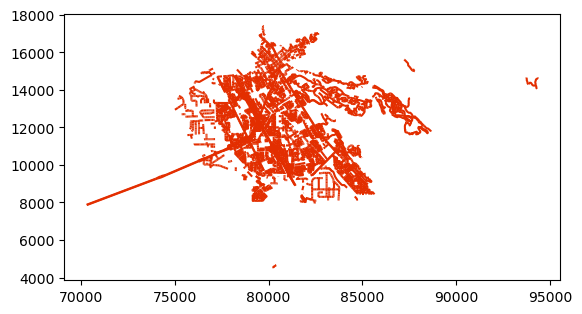

In [68]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['en_bike_ex']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

In [69]:
sf_motor_network.groupby(['exist_lts1'])['exist_lts1'].count()

exist_lts1
0       3
1    4460
2     164
3     731
4    1137
Name: exist_lts1, dtype: int64

<AxesSubplot: >

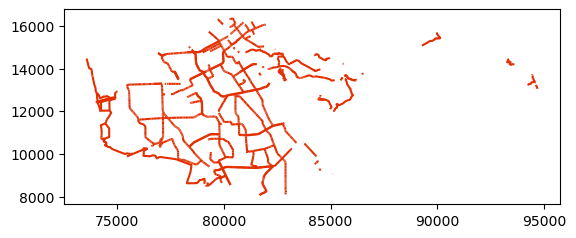

In [70]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['en_bike_ex']!='0']
sf_bike_network.plot(color='#e32e00')

In [71]:
sf_bike_network.groupby(['exist_lts1'])['exist_lts1'].count()

exist_lts1
1    274
2    743
3    556
4    689
Name: exist_lts1, dtype: int64

In [72]:
sf_bike_network.shape

(2262, 46)

In [73]:
input_census_tract=census_track2.reset_index()
input_census_tract.shape

(51, 17)

In [76]:
al_connectivity=node_level_connectivity_score (sf_motor_network,sf_bike_network)
al_connectivity.head()

,total_motor_path,nodeID_x,geometry,total_bike_path,nodeID_y,CS
0,514.383541,0.0,POINT (80271.739 4500.060),0.0,0.0,0.0
1,514.383541,1.0,POINT (80406.529 4672.282),0.0,0.0,0.0
2,9217.881655,2.0,POINT (80400.894 9020.744),0.0,0.0,0.0
3,9577.248938,3.0,POINT (80411.455 9020.253),0.0,0.0,0.0
4,8729.791078,4.0,POINT (80384.636 9021.502),0.0,0.0,0.0


In [77]:
# overall Area Connectivity
BMN_Area_CS=al_connectivity['total_bike_path'].sum()/al_connectivity['total_motor_path'].sum()
BMN_Area_CS

0.3386813174175391

In [78]:
al_connectivity['CS'].median()

0.0

In [79]:
# Save the Alamenda County node level Connectivity
crs = {'init': 'epsg:7131'}
gdf_al = gpd.GeoDataFrame(al_connectivity, crs=crs, geometry = 'geometry')
gdf_al.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/hayward_existing_network_BMN_node_level_connectivity.shp")

In [80]:
# save the results by Census Tract
CS_median=census_node_level_connectivity_score (al_connectivity,input_census_tract)
CS_median.head()

,GISJOIN,Meadian CS,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600010431200,0.0,4388,06,001,431200,06001431200,4312,Census Tract 4312,G5020,S,2025757.0,26007.0,+37.6871184,-122.0834504,6868.165374,2.051761e+06,"MULTIPOLYGON (((80975.955 16169.681, 80957.453..."
1,G0600010435102,0.0,4413,06,001,435102,06001435102,4351.02,Census Tract 4351.02,G5020,S,4213399.0,0.0,+37.6552160,-122.0457895,16199.793417,4.213400e+06,"POLYGON ((85583.942 14233.847, 85589.242 14232..."
2,G0600010435103,0.0,4414,06,001,435103,06001435103,4351.03,Census Tract 4351.03,G5020,S,51789793.0,0.0,+37.6516747,-121.9827815,56138.943540,5.178979e+07,"MULTIPOLYGON (((89497.310 16292.188, 89497.758..."
3,G0600010435104,0.0,4415,06,001,435104,06001435104,4351.04,Census Tract 4351.04,G5020,S,7240655.0,0.0,+37.6385144,-122.0388422,15117.356710,7.240652e+06,"MULTIPOLYGON (((84558.403 12484.322, 84572.351..."
4,G0600010435200,0.0,4416,06,001,435200,06001435200,4352,Census Tract 4352,G5020,S,2255836.0,61592.0,+37.6880455,-122.0490826,7906.846198,2.317429e+06,"POLYGON ((82548.025 16770.361, 82535.946 16769..."


In [81]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
CS_median1 = gpd.GeoDataFrame(CS_median, crs=crs, geometry = 'geometry')
CS_median1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Hayward_existing_network_Census_level_Median_BMN_CS.shp")

# Assign the Grade of the Connectivity for Bike Network-micro connectivity

In [82]:
CS_median['cs_ranking']=CS_median.apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected     6
fairly connected          1
poorly connected         39
Name: GISJOIN, dtype: int64

# Assign the Grade of the Connectivity for Bike Network-macro connectivity

In [83]:
# Join the nodel level shortest path results with census tract
AC=gpd.sjoin(al_connectivity,input_census_tract)
# aggregrate total bike path by census tract
AC1=pd.DataFrame({'total_bike_path':AC.groupby(['GISJOIN'])['total_bike_path'].sum()}).reset_index()
# aggregrate total motor path by census tract
AC2=pd.DataFrame({'total_motor_path':AC.groupby(['GISJOIN'])['total_motor_path'].sum()}).reset_index()
# join total bike and motor path processing data by census tract GISJOIN id
ACS=pd.merge(AC1, AC2, on=['GISJOIN'], how='inner')
# calculate area connectivity by each census tract
ACS['ACS']=ACS['total_bike_path']/ACS['total_motor_path']
# assigm the grade of the census tract
ACS['cs_ranking']=ACS.apply(lambda row:count_census_block(row['ACS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
ACS.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    12
fairly connected          7
poorly connected         23
very well connected       1
well connected            3
Name: GISJOIN, dtype: int64

# Calculate Low Stress Network Connectivity

<AxesSubplot: >

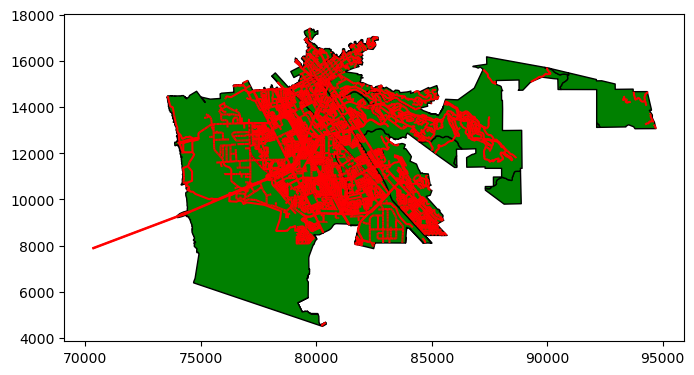

In [84]:
fig, ax = plt.subplots(figsize = (8,8)) 
census_track3_sf.plot(ax=ax,color="green",edgecolor='k')
sf_lts.geometry.plot(color="red",edgecolor='k',ax=ax)

In [86]:
# Split the network as low network to get the connectivity 
sf_motor_network_op2=sf_motor_network
sf_low_stress_network_op2=sf_lts.loc[sf_lts['exist_lts1']<3]

In [87]:
node_level_MLN_CS= node_level_connectivity_score(sf_motor_network_op2,sf_low_stress_network_op2)
node_level_MLN_CS.head()

,total_motor_path,nodeID_x,geometry,total_bike_path,nodeID_y,CS
0,514.383541,0.0,POINT (80271.739 4500.060),5.143835e+02,0.0,1.000000
1,514.383541,1.0,POINT (80406.529 4672.282),5.143835e+02,1.0,1.000000
2,9217.881655,2.0,POINT (80400.894 9020.744),1.491060e+06,6.0,161.757319
3,9577.248938,3.0,POINT (80411.455 9020.253),1.495922e+06,7.0,156.195361
4,8729.791078,4.0,POINT (80384.636 9021.502),1.483641e+06,8.0,169.951472


In [88]:
# overall Area Connectivity
LMN_Area_CS=node_level_MLN_CS['total_bike_path'].sum()/node_level_MLN_CS['total_motor_path'].sum()
LMN_Area_CS

0.014659505810128383

In [89]:
node_level_MLN_CS['CS'].median()

0.0262198496301476

In [90]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
sfcs1 = gpd.GeoDataFrame(node_level_MLN_CS, crs=crs, geometry = 'geometry')
sfcs1.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/Hayward_existing_node_level_LMN_CS.shp")

In [91]:
CS_median1=census_node_level_connectivity_score (node_level_MLN_CS,input_census_tract)
CS_median1.head()

,GISJOIN,Meadian CS,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0600010431200,0.000015,4388,06,001,431200,06001431200,4312,Census Tract 4312,G5020,S,2025757.0,26007.0,+37.6871184,-122.0834504,6868.165374,2.051761e+06,"MULTIPOLYGON (((80975.955 16169.681, 80957.453..."
1,G0600010435102,1.000000,4413,06,001,435102,06001435102,4351.02,Census Tract 4351.02,G5020,S,4213399.0,0.0,+37.6552160,-122.0457895,16199.793417,4.213400e+06,"POLYGON ((85583.942 14233.847, 85589.242 14232..."
2,G0600010435103,0.433571,4414,06,001,435103,06001435103,4351.03,Census Tract 4351.03,G5020,S,51789793.0,0.0,+37.6516747,-121.9827815,56138.943540,5.178979e+07,"MULTIPOLYGON (((89497.310 16292.188, 89497.758..."
3,G0600010435104,0.000712,4415,06,001,435104,06001435104,4351.04,Census Tract 4351.04,G5020,S,7240655.0,0.0,+37.6385144,-122.0388422,15117.356710,7.240652e+06,"MULTIPOLYGON (((84558.403 12484.322, 84572.351..."
4,G0600010435200,0.048071,4416,06,001,435200,06001435200,4352,Census Tract 4352,G5020,S,2255836.0,61592.0,+37.6880455,-122.0490826,7906.846198,2.317429e+06,"POLYGON ((82548.025 16770.361, 82535.946 16769..."


In [92]:
# Import the node Connectivity
crs = {'init': 'epsg:7131'}
CS_median2 = gpd.GeoDataFrame(CS_median1, crs=crs, geometry = 'geometry')
CS_median2.to_file("H:/mmmiah/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Nodel Level Connectivity_results/hayward_existing_census_level_LMN_CS.shp")

# Assign the Grade of the Connectivity for Bike Network-micro connectivity

In [93]:
CS_median1 ['cs_ranking']=CS_median1 .apply(lambda row:count_census_block(row['Meadian CS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
CS_median1.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    15
fairly connected          1
poorly connected         28
very well connected       1
well connected            1
Name: GISJOIN, dtype: int64

# Assign the Grade of the Connectivity for low stress Network-macro connectivity

In [94]:
# Join the nodel level shortest path results with census tract
AC=gpd.sjoin(node_level_MLN_CS,input_census_tract)
# aggregrate total bike path by census tract
AC1=pd.DataFrame({'total_bike_path':AC.groupby(['GISJOIN'])['total_bike_path'].sum()}).reset_index()
# aggregrate total motor path by census tract
AC2=pd.DataFrame({'total_motor_path':AC.groupby(['GISJOIN'])['total_motor_path'].sum()}).reset_index()
# join total bike and motor path processing data by census tract GISJOIN id
ACS=pd.merge(AC1, AC2, on=['GISJOIN'], how='inner')
# calculate area connectivity by each census tract
ACS['ACS']=ACS['total_bike_path']/ACS['total_motor_path']
# assigm the grade of the census tract
ACS['cs_ranking']=ACS.apply(lambda row:count_census_block(row['ACS']),axis=1 )
# Now count the census tract for Bay area by cs ranking
ACS.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected     6
fairly connected          3
poorly connected         36
well connected            1
Name: GISJOIN, dtype: int64

# End of coding